In [83]:
import numpy as np
import pandas as pd
import datetime

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

pd.options.display.max_columns = 300

In [84]:
df_train = pd.read_csv('../input/20181216_train.csv')
df_test = pd.read_csv('../input/20181216_test.csv')

In [85]:
def merge_new_feature(path, use=[]):
    if len(use) > 1:
        df_new_feature = pd.read_csv(path, usecols=use)
    else:
        df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [86]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")

In [87]:
dont_use = [
    'card_id', 
    'first_active_month',
    'second_active_date',
    'diff_first_and_second',
    'target','outliers', 
    'category_1_Y_std', 
    'hist_purchase_date_max',
    'hist_purchase_date_min',
    'hist_category_2_mean_mean',
    'hist_category_3_mean_mean'
]

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [88]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [89]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【card_id_count】
0.9935317230513652



【hist_authorized_flag_sum】 --- 【authorized_flag_ture】
0.9979558326172671



【hist_authorized_flag_sum】 --- 【authorized_flag_ture_weighted_elapsed】
0.9979558326172671



【hist_authorized_flag_mean】 --- 【authorized_flag_ture_rate】
0.9871399739794636



【hist_category_1_sum】 --- 【category_1_true】
0.9996032083806138



【hist_category_1_sum】 --- 【category_1_true_weighted_elapsed】
0.9996032083806138



【hist_category_1_mean】 --- 【category_1_true_rate】
0.9915584786977886



【hist_card_id_size】 --- 【card_id_count】
0.9981205383400666



【hist_card_id_size】 --- 【authorized_flag_ture】
0.991907744189161



【hist_card_id_size】 --- 【authorized_flag_ture_weighted_elapsed】
0.991907744189161



【hist_purchase_date_diff】 --- 【elapsed_from_oldest_purchase_date_to_latest_purchase_date】
0.968714472679401



【new_hist_purchase_date_max】 --- 【new_hist_purchase_date_min

In [90]:
sorted(set(drop_col))

['authorized_flag_ture',
 'authorized_flag_ture_rate',
 'authorized_flag_ture_weighted_elapsed',
 'card_id_count',
 'category_1_true',
 'category_1_true_rate',
 'category_1_true_weighted_elapsed',
 'category_3_A_latest_trs',
 'elapsed_from_oldest_purchase_date_to_first_active',
 'elapsed_from_oldest_purchase_date_to_latest_purchase_date',
 'hist_card_id_size',
 'installments_0',
 'installments_0_rate',
 'installments_0_weighted_elapsed',
 'installments_1',
 'installments_1_rate',
 'installments_1_weighted_elapsed',
 'month_lag_N10_weighted_elapsed',
 'month_lag_N11_weighted_elapsed',
 'month_lag_N12_weighted_elapsed',
 'month_lag_N13_weighted_elapsed',
 'month_lag_N8_weighted_elapsed',
 'month_lag_N9_weighted_elapsed',
 'most_recent_purchases_range_null_latest_trs',
 'most_recent_sales_range_null_latest_trs',
 'new_hist_purchase_date_min',
 'numerical_1_null_latest_trs']

In [91]:
len(df_train_columns)

270

In [92]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
        
roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.910441	valid_1's auc: 0.895916
[200]	training's auc: 0.927627	valid_1's auc: 0.90123
[300]	training's auc: 0.938233	valid_1's auc: 0.903992
[400]	training's auc: 0.947873	valid_1's auc: 0.905184
[500]	training's auc: 0.956885	valid_1's auc: 0.905638
[600]	training's auc: 0.964325	valid_1's auc: 0.905919
[700]	training's auc: 0.9702	valid_1's auc: 0.905724
[800]	training's auc: 0.974454	valid_1's auc: 0.905324
[900]	training's auc: 0.977976	valid_1's auc: 0.90479
Early stopping, best iteration is:
[521]	training's auc: 0.958634	valid_1's auc: 0.906071
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911729	valid_1's auc: 0.883662
[200]	training's auc: 0.929097	valid_1's auc: 0.888554
[300]	training's auc: 0.939372	valid_1's auc: 0.891455
[400]	training's auc: 0.949437	valid_1's auc: 0.894259
[500]	training's auc: 0.957489	valid_1's auc: 0.895348
[600

0.9013241810502891

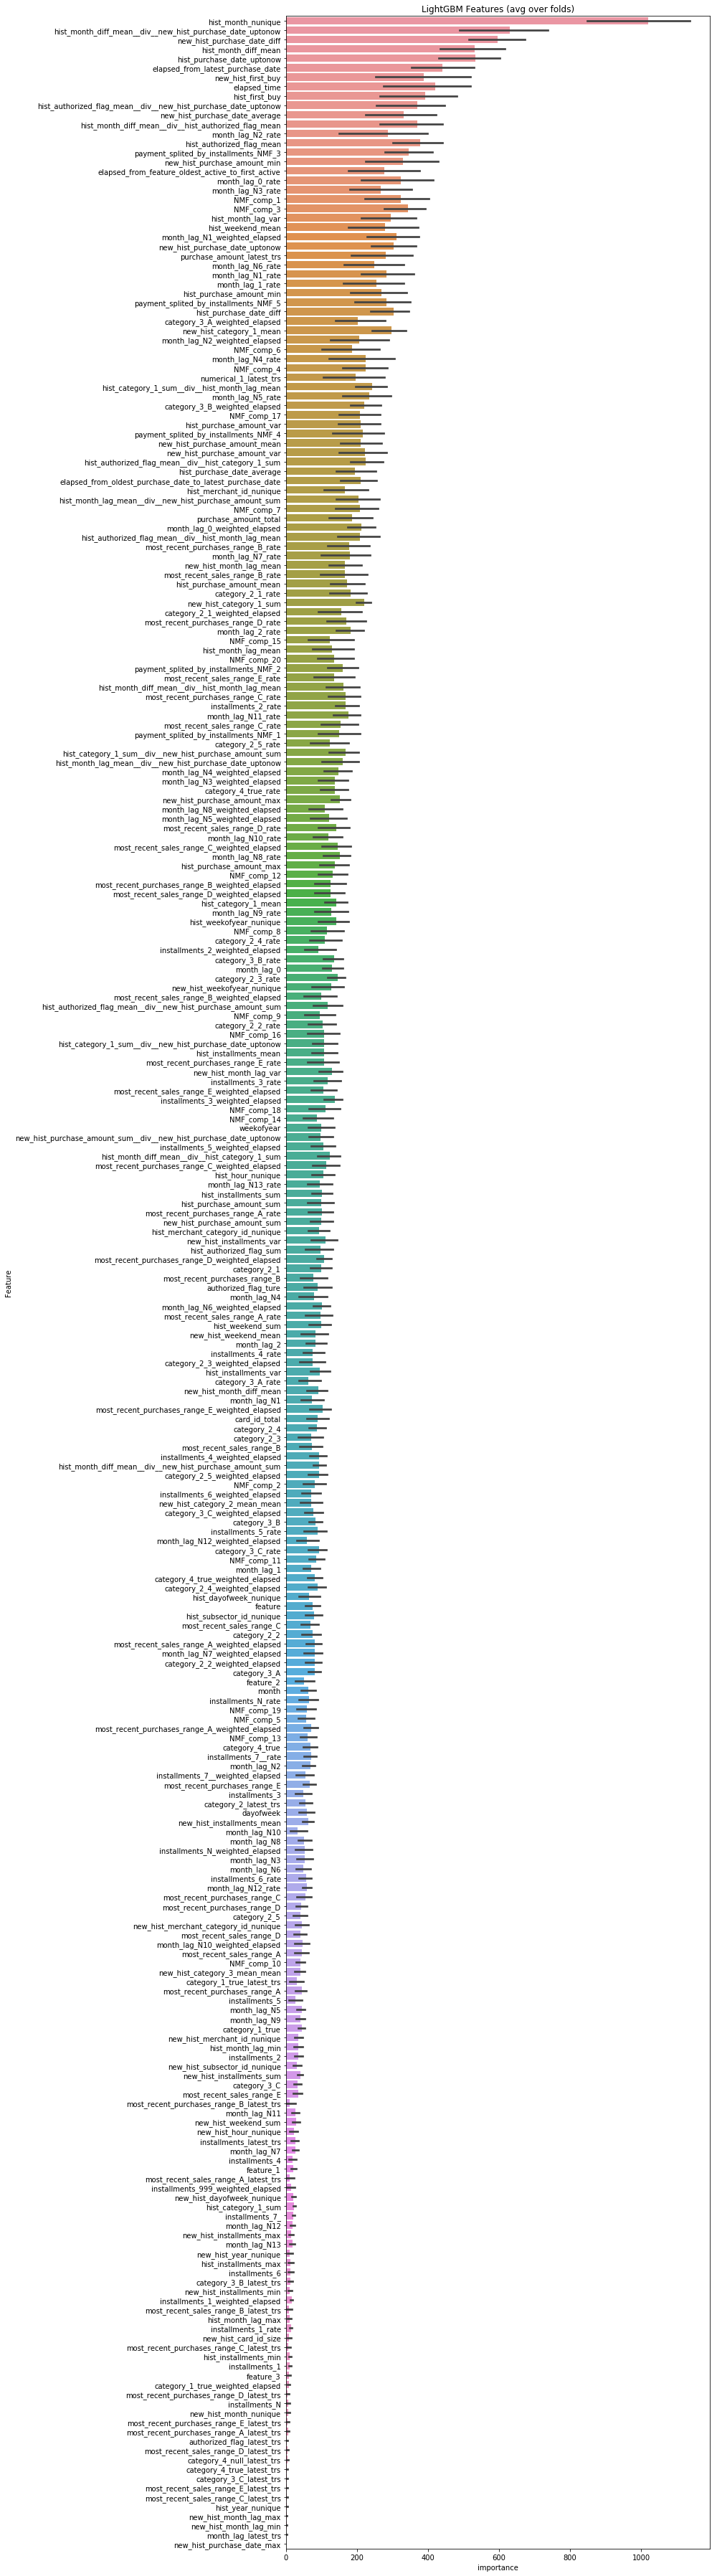

In [93]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [96]:
df_train_columns2 = cols[:200]

matrix_prob = np.zeros([df_test.shape[0]])

iteration = 30

for i in range(iteration):
    
    param = {
        'num_leaves': 31,  # 31
        'min_data_in_leaf': 30,
        'objective':'binary',  #regression
        'max_depth': 8,  # -1
        'learning_rate': 0.004,
        "min_child_samples": 20,
        "boosting": "gbdt",
        "feature_fraction": 0.9,
        "bagging_freq": 1,
        "bagging_fraction": 0.9 ,
        "bagging_seed": 11,
        "metric": 'auc',  #auc
        "lambda_l1": 0.1,
        "verbosity": -1,
        "nthread": 4,
        "random_state": i
    }
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=i) #4590
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target_outlier.iloc[trn_idx])
        val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target_outlier.iloc[val_idx])

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = df_train_columns2
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits
        matrix_prob += predictions/iteration

    print(roc_auc_score(target_outlier, oof))
    
    print("\n"*2)
    print("===== Process {} completed =====".format(i+1))
    print("\n"*2)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.910185	valid_1's auc: 0.880021
[200]	training's auc: 0.925807	valid_1's auc: 0.888978
[300]	training's auc: 0.936578	valid_1's auc: 0.893058
[400]	training's auc: 0.947078	valid_1's auc: 0.896019
[500]	training's auc: 0.955265	valid_1's auc: 0.897751
[600]	training's auc: 0.96331	valid_1's auc: 0.899037
[700]	training's auc: 0.969871	valid_1's auc: 0.899692
[800]	training's auc: 0.97433	valid_1's auc: 0.900472
[900]	training's auc: 0.977811	valid_1's auc: 0.900829
[1000]	training's auc: 0.980569	valid_1's auc: 0.901274
[1100]	training's auc: 0.98263	valid_1's auc: 0.901425
[1200]	training's auc: 0.984583	valid_1's auc: 0.901601
[1300]	training's auc: 0.986323	valid_1's auc: 0.901598
[1400]	training's auc: 0.98801	valid_1's auc: 0.901659
[1500]	training's auc: 0.989329	valid_1's auc: 0.901814
[1600]	training's auc: 0.990582	valid_1's auc: 0.901847
[1700]	training's auc: 0.991624	valid_1's auc: 

[1300]	training's auc: 0.987745	valid_1's auc: 0.902605
[1400]	training's auc: 0.989229	valid_1's auc: 0.90263
[1500]	training's auc: 0.990496	valid_1's auc: 0.902621
[1600]	training's auc: 0.991544	valid_1's auc: 0.902595
[1700]	training's auc: 0.992535	valid_1's auc: 0.902642
Early stopping, best iteration is:
[1319]	training's auc: 0.988003	valid_1's auc: 0.902681
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911117	valid_1's auc: 0.883517
[200]	training's auc: 0.924767	valid_1's auc: 0.890267
[300]	training's auc: 0.937577	valid_1's auc: 0.893761
[400]	training's auc: 0.947328	valid_1's auc: 0.895496
[500]	training's auc: 0.956148	valid_1's auc: 0.89694
[600]	training's auc: 0.963639	valid_1's auc: 0.897816
[700]	training's auc: 0.969828	valid_1's auc: 0.898789
[800]	training's auc: 0.974567	valid_1's auc: 0.898975
[900]	training's auc: 0.978379	valid_1's auc: 0.899073
[1000]	training's auc: 0.981097	valid_1's auc: 0.899078
[1100]	tra

[2200]	training's auc: 0.995403	valid_1's auc: 0.911478
[2300]	training's auc: 0.995919	valid_1's auc: 0.911515
Early stopping, best iteration is:
[1964]	training's auc: 0.993967	valid_1's auc: 0.91156
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.909518	valid_1's auc: 0.890429
[200]	training's auc: 0.924927	valid_1's auc: 0.898046
[300]	training's auc: 0.937761	valid_1's auc: 0.902056
[400]	training's auc: 0.948942	valid_1's auc: 0.903605
[500]	training's auc: 0.95742	valid_1's auc: 0.904447
[600]	training's auc: 0.964687	valid_1's auc: 0.904979
[700]	training's auc: 0.970559	valid_1's auc: 0.905086
[800]	training's auc: 0.97524	valid_1's auc: 0.904662
[900]	training's auc: 0.978422	valid_1's auc: 0.904556
[1000]	training's auc: 0.981189	valid_1's auc: 0.9044
Early stopping, best iteration is:
[646]	training's auc: 0.967629	valid_1's auc: 0.905223
0.9023009485185327



===== Process 3 completed =====



fold 0
Training until validation s

[900]	training's auc: 0.97741	valid_1's auc: 0.906394
[1000]	training's auc: 0.980214	valid_1's auc: 0.906309
[1100]	training's auc: 0.982586	valid_1's auc: 0.906318
[1200]	training's auc: 0.984542	valid_1's auc: 0.906197
Early stopping, best iteration is:
[816]	training's auc: 0.974424	valid_1's auc: 0.906511
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.910884	valid_1's auc: 0.886073
[200]	training's auc: 0.92765	valid_1's auc: 0.891316
[300]	training's auc: 0.938031	valid_1's auc: 0.895455
[400]	training's auc: 0.947362	valid_1's auc: 0.898312
[500]	training's auc: 0.955614	valid_1's auc: 0.899471
[600]	training's auc: 0.962774	valid_1's auc: 0.900889
[700]	training's auc: 0.968639	valid_1's auc: 0.902032
[800]	training's auc: 0.973129	valid_1's auc: 0.902558
[900]	training's auc: 0.976752	valid_1's auc: 0.903095
[1000]	training's auc: 0.979733	valid_1's auc: 0.903368
[1100]	training's auc: 0.982193	valid_1's auc: 0.903586
[1200]	train

[100]	training's auc: 0.911024	valid_1's auc: 0.891881
[200]	training's auc: 0.927456	valid_1's auc: 0.896477
[300]	training's auc: 0.939704	valid_1's auc: 0.898326
[400]	training's auc: 0.949228	valid_1's auc: 0.899611
[500]	training's auc: 0.957143	valid_1's auc: 0.900391
[600]	training's auc: 0.9646	valid_1's auc: 0.901053
[700]	training's auc: 0.970424	valid_1's auc: 0.901896
[800]	training's auc: 0.974891	valid_1's auc: 0.902321
[900]	training's auc: 0.978422	valid_1's auc: 0.902631
[1000]	training's auc: 0.980884	valid_1's auc: 0.902811
[1100]	training's auc: 0.983058	valid_1's auc: 0.902941
[1200]	training's auc: 0.984838	valid_1's auc: 0.902905
[1300]	training's auc: 0.986453	valid_1's auc: 0.902911
[1400]	training's auc: 0.98791	valid_1's auc: 0.902883
[1500]	training's auc: 0.98919	valid_1's auc: 0.902833
Early stopping, best iteration is:
[1144]	training's auc: 0.983879	valid_1's auc: 0.903017
0.9036087306204328



===== Process 6 completed =====



fold 0
Training until val

[1000]	training's auc: 0.979971	valid_1's auc: 0.90992
[1100]	training's auc: 0.982316	valid_1's auc: 0.910046
[1200]	training's auc: 0.984509	valid_1's auc: 0.910155
[1300]	training's auc: 0.98644	valid_1's auc: 0.910032
[1400]	training's auc: 0.988158	valid_1's auc: 0.910002
[1500]	training's auc: 0.989524	valid_1's auc: 0.909912
[1600]	training's auc: 0.99077	valid_1's auc: 0.909878
Early stopping, best iteration is:
[1229]	training's auc: 0.985057	valid_1's auc: 0.910203
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.910544	valid_1's auc: 0.884685
[200]	training's auc: 0.927172	valid_1's auc: 0.890233
[300]	training's auc: 0.938081	valid_1's auc: 0.894195
[400]	training's auc: 0.94914	valid_1's auc: 0.896854
[500]	training's auc: 0.956809	valid_1's auc: 0.897998
[600]	training's auc: 0.964594	valid_1's auc: 0.898824
[700]	training's auc: 0.970244	valid_1's auc: 0.899471
[800]	training's auc: 0.974796	valid_1's auc: 0.899544
[900]	train

[500]	training's auc: 0.955862	valid_1's auc: 0.901884
[600]	training's auc: 0.964291	valid_1's auc: 0.90259
[700]	training's auc: 0.970351	valid_1's auc: 0.903105
[800]	training's auc: 0.974925	valid_1's auc: 0.903616
[900]	training's auc: 0.978437	valid_1's auc: 0.90399
[1000]	training's auc: 0.98127	valid_1's auc: 0.904598
[1100]	training's auc: 0.983472	valid_1's auc: 0.904761
[1200]	training's auc: 0.985393	valid_1's auc: 0.904979
[1300]	training's auc: 0.987166	valid_1's auc: 0.905353
[1400]	training's auc: 0.988532	valid_1's auc: 0.905453
[1500]	training's auc: 0.989758	valid_1's auc: 0.905425
[1600]	training's auc: 0.990917	valid_1's auc: 0.905514
[1700]	training's auc: 0.99192	valid_1's auc: 0.905541
[1800]	training's auc: 0.992799	valid_1's auc: 0.90552
[1900]	training's auc: 0.993646	valid_1's auc: 0.905487
[2000]	training's auc: 0.994398	valid_1's auc: 0.905438
Early stopping, best iteration is:
[1612]	training's auc: 0.99102	valid_1's auc: 0.905588
0.9032040182777943



==

[900]	training's auc: 0.977254	valid_1's auc: 0.91024
[1000]	training's auc: 0.979903	valid_1's auc: 0.910374
[1100]	training's auc: 0.982211	valid_1's auc: 0.910569
[1200]	training's auc: 0.984387	valid_1's auc: 0.910639
[1300]	training's auc: 0.986171	valid_1's auc: 0.910745
[1400]	training's auc: 0.987802	valid_1's auc: 0.910693
[1500]	training's auc: 0.989236	valid_1's auc: 0.910722
[1600]	training's auc: 0.990433	valid_1's auc: 0.910738
[1700]	training's auc: 0.991592	valid_1's auc: 0.910699
Early stopping, best iteration is:
[1312]	training's auc: 0.986366	valid_1's auc: 0.910788
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911588	valid_1's auc: 0.885324
[200]	training's auc: 0.926688	valid_1's auc: 0.891791
[300]	training's auc: 0.937084	valid_1's auc: 0.893988
[400]	training's auc: 0.946556	valid_1's auc: 0.896284
[500]	training's auc: 0.955181	valid_1's auc: 0.897732
[600]	training's auc: 0.962901	valid_1's auc: 0.899059
[700]	t

[800]	training's auc: 0.97546	valid_1's auc: 0.899988
[900]	training's auc: 0.978601	valid_1's auc: 0.900684
[1000]	training's auc: 0.981177	valid_1's auc: 0.901082
[1100]	training's auc: 0.983456	valid_1's auc: 0.901251
[1200]	training's auc: 0.985428	valid_1's auc: 0.901288
[1300]	training's auc: 0.987042	valid_1's auc: 0.901345
[1400]	training's auc: 0.988505	valid_1's auc: 0.901383
[1500]	training's auc: 0.989969	valid_1's auc: 0.901477
[1600]	training's auc: 0.991127	valid_1's auc: 0.901509
[1700]	training's auc: 0.992183	valid_1's auc: 0.901335
[1800]	training's auc: 0.99309	valid_1's auc: 0.901266
[1900]	training's auc: 0.993891	valid_1's auc: 0.901206
Early stopping, best iteration is:
[1531]	training's auc: 0.990333	valid_1's auc: 0.901557
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911117	valid_1's auc: 0.890081
[200]	training's auc: 0.927512	valid_1's auc: 0.895538
[300]	training's auc: 0.937497	valid_1's auc: 0.898086
[400]	

Early stopping, best iteration is:
[609]	training's auc: 0.964338	valid_1's auc: 0.91034
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.909013	valid_1's auc: 0.897103
[200]	training's auc: 0.924122	valid_1's auc: 0.905205
[300]	training's auc: 0.936373	valid_1's auc: 0.908247
[400]	training's auc: 0.945914	valid_1's auc: 0.909874
[500]	training's auc: 0.95415	valid_1's auc: 0.910399
[600]	training's auc: 0.962013	valid_1's auc: 0.911441
[700]	training's auc: 0.968162	valid_1's auc: 0.912062
[800]	training's auc: 0.973185	valid_1's auc: 0.912319
[900]	training's auc: 0.976954	valid_1's auc: 0.912571
[1000]	training's auc: 0.979882	valid_1's auc: 0.912795
[1100]	training's auc: 0.982134	valid_1's auc: 0.912723
[1200]	training's auc: 0.984184	valid_1's auc: 0.912707
[1300]	training's auc: 0.986062	valid_1's auc: 0.912542
Early stopping, best iteration is:
[943]	training's auc: 0.978257	valid_1's auc: 0.912828
fold 2
Training until validation 

[800]	training's auc: 0.973186	valid_1's auc: 0.902739
[900]	training's auc: 0.976949	valid_1's auc: 0.902831
[1000]	training's auc: 0.979958	valid_1's auc: 0.902991
[1100]	training's auc: 0.982256	valid_1's auc: 0.903184
[1200]	training's auc: 0.984364	valid_1's auc: 0.903258
[1300]	training's auc: 0.986138	valid_1's auc: 0.903386
[1400]	training's auc: 0.987757	valid_1's auc: 0.90351
[1500]	training's auc: 0.989228	valid_1's auc: 0.903588
[1600]	training's auc: 0.990488	valid_1's auc: 0.903633
[1700]	training's auc: 0.991623	valid_1's auc: 0.90366
[1800]	training's auc: 0.992559	valid_1's auc: 0.903528
[1900]	training's auc: 0.99349	valid_1's auc: 0.903616
[2000]	training's auc: 0.99425	valid_1's auc: 0.903792
[2100]	training's auc: 0.994918	valid_1's auc: 0.903703
[2200]	training's auc: 0.995493	valid_1's auc: 0.903759
[2300]	training's auc: 0.995985	valid_1's auc: 0.903651
[2400]	training's auc: 0.996452	valid_1's auc: 0.903761
[2500]	training's auc: 0.996873	valid_1's auc: 0.90381

[1200]	training's auc: 0.984889	valid_1's auc: 0.907358
[1300]	training's auc: 0.986675	valid_1's auc: 0.907284
[1400]	training's auc: 0.988247	valid_1's auc: 0.907251
[1500]	training's auc: 0.989639	valid_1's auc: 0.907177
Early stopping, best iteration is:
[1123]	training's auc: 0.983245	valid_1's auc: 0.907465
0.9039202289627164



===== Process 16 completed =====



fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911761	valid_1's auc: 0.887812
[200]	training's auc: 0.927178	valid_1's auc: 0.893936
[300]	training's auc: 0.939756	valid_1's auc: 0.897491
[400]	training's auc: 0.9494	valid_1's auc: 0.899182
[500]	training's auc: 0.957802	valid_1's auc: 0.900607
[600]	training's auc: 0.964772	valid_1's auc: 0.901293
[700]	training's auc: 0.970543	valid_1's auc: 0.901789
[800]	training's auc: 0.975034	valid_1's auc: 0.902308
[900]	training's auc: 0.978356	valid_1's auc: 0.902863
[1000]	training's auc: 0.981012	valid_1's auc: 0.903342
[1100]	t

[700]	training's auc: 0.967864	valid_1's auc: 0.908877
[800]	training's auc: 0.973135	valid_1's auc: 0.908846
[900]	training's auc: 0.977155	valid_1's auc: 0.909146
Early stopping, best iteration is:
[543]	training's auc: 0.957284	valid_1's auc: 0.909261
fold 3
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.90965	valid_1's auc: 0.872379
[200]	training's auc: 0.926306	valid_1's auc: 0.88393
[300]	training's auc: 0.938793	valid_1's auc: 0.888358
[400]	training's auc: 0.949803	valid_1's auc: 0.892296
[500]	training's auc: 0.957828	valid_1's auc: 0.893863
[600]	training's auc: 0.964592	valid_1's auc: 0.894501
[700]	training's auc: 0.970105	valid_1's auc: 0.894996
[800]	training's auc: 0.974875	valid_1's auc: 0.895558
[900]	training's auc: 0.978358	valid_1's auc: 0.895945
[1000]	training's auc: 0.981017	valid_1's auc: 0.896262
[1100]	training's auc: 0.983167	valid_1's auc: 0.896365
[1200]	training's auc: 0.985012	valid_1's auc: 0.896487
[1300]	trainin

[1200]	training's auc: 0.984961	valid_1's auc: 0.901153
[1300]	training's auc: 0.986793	valid_1's auc: 0.901003
[1400]	training's auc: 0.988318	valid_1's auc: 0.900998
[1500]	training's auc: 0.989599	valid_1's auc: 0.900869
Early stopping, best iteration is:
[1159]	training's auc: 0.984241	valid_1's auc: 0.901262
0.9037185159986285



===== Process 19 completed =====



fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.907811	valid_1's auc: 0.898712
[200]	training's auc: 0.923091	valid_1's auc: 0.903146
[300]	training's auc: 0.936166	valid_1's auc: 0.907089
[400]	training's auc: 0.946588	valid_1's auc: 0.909051
[500]	training's auc: 0.955253	valid_1's auc: 0.910286
[600]	training's auc: 0.962322	valid_1's auc: 0.910676
[700]	training's auc: 0.96946	valid_1's auc: 0.911102
[800]	training's auc: 0.97421	valid_1's auc: 0.911289
[900]	training's auc: 0.97746	valid_1's auc: 0.911227
[1000]	training's auc: 0.980255	valid_1's auc: 0.911407
[1100]	tr

[2000]	training's auc: 0.994122	valid_1's auc: 0.911958
[2100]	training's auc: 0.994799	valid_1's auc: 0.911963
[2200]	training's auc: 0.995394	valid_1's auc: 0.911944
[2300]	training's auc: 0.995922	valid_1's auc: 0.911952
[2400]	training's auc: 0.996398	valid_1's auc: 0.911895
[2500]	training's auc: 0.996828	valid_1's auc: 0.911872
Early stopping, best iteration is:
[2138]	training's auc: 0.995017	valid_1's auc: 0.912005
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911829	valid_1's auc: 0.878627
[200]	training's auc: 0.928139	valid_1's auc: 0.886134
[300]	training's auc: 0.939311	valid_1's auc: 0.889582
[400]	training's auc: 0.949525	valid_1's auc: 0.892313
[500]	training's auc: 0.958363	valid_1's auc: 0.893574
[600]	training's auc: 0.965263	valid_1's auc: 0.894995
[700]	training's auc: 0.970728	valid_1's auc: 0.895846
[800]	training's auc: 0.974928	valid_1's auc: 0.896723
[900]	training's auc: 0.97818	valid_1's auc: 0.897442
[1000]	tr

[1500]	training's auc: 0.989465	valid_1's auc: 0.90604
[1600]	training's auc: 0.990685	valid_1's auc: 0.905993
Early stopping, best iteration is:
[1216]	training's auc: 0.985176	valid_1's auc: 0.906156
0.9043875989918051



===== Process 22 completed =====



fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.913231	valid_1's auc: 0.878631
[200]	training's auc: 0.927802	valid_1's auc: 0.881246
[300]	training's auc: 0.93996	valid_1's auc: 0.884485
[400]	training's auc: 0.949697	valid_1's auc: 0.887457
[500]	training's auc: 0.957874	valid_1's auc: 0.888921
[600]	training's auc: 0.964898	valid_1's auc: 0.889778
[700]	training's auc: 0.970784	valid_1's auc: 0.890595
[800]	training's auc: 0.975548	valid_1's auc: 0.891309
[900]	training's auc: 0.979029	valid_1's auc: 0.891974
[1000]	training's auc: 0.981555	valid_1's auc: 0.892324
[1100]	training's auc: 0.983765	valid_1's auc: 0.892513
[1200]	training's auc: 0.985616	valid_1's auc: 0.892648
[1300]	t

[500]	training's auc: 0.956365	valid_1's auc: 0.899778
[600]	training's auc: 0.963101	valid_1's auc: 0.900233
[700]	training's auc: 0.968909	valid_1's auc: 0.900846
[800]	training's auc: 0.973655	valid_1's auc: 0.901202
[900]	training's auc: 0.977151	valid_1's auc: 0.901541
[1000]	training's auc: 0.979949	valid_1's auc: 0.90169
[1100]	training's auc: 0.98231	valid_1's auc: 0.901858
[1200]	training's auc: 0.984483	valid_1's auc: 0.901965
[1300]	training's auc: 0.986171	valid_1's auc: 0.902116
[1400]	training's auc: 0.987788	valid_1's auc: 0.902123
[1500]	training's auc: 0.989264	valid_1's auc: 0.902172
[1600]	training's auc: 0.990575	valid_1's auc: 0.902209
[1700]	training's auc: 0.991676	valid_1's auc: 0.902099
[1800]	training's auc: 0.992621	valid_1's auc: 0.90213
[1900]	training's auc: 0.993474	valid_1's auc: 0.901985
Early stopping, best iteration is:
[1553]	training's auc: 0.989995	valid_1's auc: 0.902248
fold 3
Training until validation scores don't improve for 400 rounds.
[100]	t

[700]	training's auc: 0.970145	valid_1's auc: 0.90279
[800]	training's auc: 0.974757	valid_1's auc: 0.902949
[900]	training's auc: 0.978101	valid_1's auc: 0.903163
[1000]	training's auc: 0.980815	valid_1's auc: 0.903334
[1100]	training's auc: 0.983121	valid_1's auc: 0.903433
[1200]	training's auc: 0.985079	valid_1's auc: 0.903575
[1300]	training's auc: 0.986855	valid_1's auc: 0.903579
[1400]	training's auc: 0.98831	valid_1's auc: 0.903334
[1500]	training's auc: 0.98962	valid_1's auc: 0.903387
[1600]	training's auc: 0.990813	valid_1's auc: 0.903353
Early stopping, best iteration is:
[1243]	training's auc: 0.985935	valid_1's auc: 0.903649
0.9035978244576068



===== Process 25 completed =====



fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.910278	valid_1's auc: 0.894897
[200]	training's auc: 0.923983	valid_1's auc: 0.899554
[300]	training's auc: 0.934744	valid_1's auc: 0.902212
[400]	training's auc: 0.945929	valid_1's auc: 0.904446
[500]	t

[1300]	training's auc: 0.986331	valid_1's auc: 0.912744
[1400]	training's auc: 0.9879	valid_1's auc: 0.912738
[1500]	training's auc: 0.989324	valid_1's auc: 0.912896
[1600]	training's auc: 0.990513	valid_1's auc: 0.912994
[1700]	training's auc: 0.991626	valid_1's auc: 0.913008
[1800]	training's auc: 0.992742	valid_1's auc: 0.912995
[1900]	training's auc: 0.993606	valid_1's auc: 0.913002
[2000]	training's auc: 0.99435	valid_1's auc: 0.912999
Early stopping, best iteration is:
[1641]	training's auc: 0.990989	valid_1's auc: 0.913056
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.912661	valid_1's auc: 0.88045
[200]	training's auc: 0.928669	valid_1's auc: 0.888948
[300]	training's auc: 0.938562	valid_1's auc: 0.891145
[400]	training's auc: 0.948412	valid_1's auc: 0.893434
[500]	training's auc: 0.957477	valid_1's auc: 0.895564
[600]	training's auc: 0.964924	valid_1's auc: 0.89703
[700]	training's auc: 0.970963	valid_1's auc: 0.898053
[800]	train

[300]	training's auc: 0.938197	valid_1's auc: 0.892329
[400]	training's auc: 0.946834	valid_1's auc: 0.894677
[500]	training's auc: 0.955093	valid_1's auc: 0.89586
[600]	training's auc: 0.962943	valid_1's auc: 0.897104
[700]	training's auc: 0.969736	valid_1's auc: 0.897964
[800]	training's auc: 0.974722	valid_1's auc: 0.898517
[900]	training's auc: 0.978331	valid_1's auc: 0.898945
[1000]	training's auc: 0.981015	valid_1's auc: 0.899173
[1100]	training's auc: 0.983269	valid_1's auc: 0.899117
[1200]	training's auc: 0.985226	valid_1's auc: 0.899055
[1300]	training's auc: 0.986907	valid_1's auc: 0.89911
[1400]	training's auc: 0.988438	valid_1's auc: 0.89896
Early stopping, best iteration is:
[1059]	training's auc: 0.982418	valid_1's auc: 0.899216
0.9022370180304714



===== Process 28 completed =====



fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.909142	valid_1's auc: 0.894193
[200]	training's auc: 0.9254	valid_1's auc: 0.90073
[300]	traini

[1400]	training's auc: 0.988089	valid_1's auc: 0.899678
[1500]	training's auc: 0.989465	valid_1's auc: 0.899689
[1600]	training's auc: 0.990717	valid_1's auc: 0.899583
[1700]	training's auc: 0.991745	valid_1's auc: 0.899436
[1800]	training's auc: 0.992706	valid_1's auc: 0.899332
Early stopping, best iteration is:
[1446]	training's auc: 0.988714	valid_1's auc: 0.899773
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.910582	valid_1's auc: 0.873415
[200]	training's auc: 0.929089	valid_1's auc: 0.882369
[300]	training's auc: 0.940464	valid_1's auc: 0.88603
[400]	training's auc: 0.950354	valid_1's auc: 0.889321
[500]	training's auc: 0.959046	valid_1's auc: 0.890785
[600]	training's auc: 0.965865	valid_1's auc: 0.891185
[700]	training's auc: 0.97127	valid_1's auc: 0.891196
[800]	training's auc: 0.975665	valid_1's auc: 0.891257
[900]	training's auc: 0.979143	valid_1's auc: 0.891511
[1000]	training's auc: 0.981918	valid_1's auc: 0.891634
[1100]	tra

In [105]:
matrix_prob

array([0.08729734, 0.00417722, 0.03474085, ..., 0.01849644, 0.17799847,
       0.0129734 ])

In [106]:
df_predict = pd.read_csv("../output/submission_model20181216.csv")
df_no_outliers_predict = pd.read_csv("../output/submission_no_outliers_model20190112.csv")

In [107]:
df_predict = pd.merge(df_predict, df_no_outliers_predict, on="card_id", how="inner")

In [108]:
df_predict["target"] = np.where(df_predict.target_x.values < 0, df_predict.target_x, df_predict.target_y)

del df_predict["target_x"]
del df_predict["target_y"]

df_predict

,card_id,target
0,C_ID_0ab67a22ab,-2.041275
1,C_ID_130fd0cbdd,-0.305701
2,C_ID_b709037bc5,-0.974894
3,C_ID_d27d835a9f,-0.090633
4,C_ID_2b5e3df5c2,-1.465622
5,C_ID_5814b4f13c,0.536912
6,C_ID_a1b3c75277,0.176816
7,C_ID_f7cada36d3,0.865616
8,C_ID_9d2bc8dfc4,-0.709276
9,C_ID_6d8dba8475,-1.145146


In [113]:
outliers_idx = np.where(predictions>0.4)[0]

In [114]:
outliers_idx.shape

(75,)

In [115]:
df_predict["target"].iloc[outliers_idx] = -25

In [116]:
df_predict[df_predict.target == -25]

,card_id,target
2624,C_ID_bd59e054f3,-25.0
4618,C_ID_c21e877db3,-25.0
5008,C_ID_be92f84f5c,-25.0
5009,C_ID_695b445408,-25.0
6026,C_ID_91cc0c06ca,-25.0
7750,C_ID_a74b12dcf8,-25.0
16074,C_ID_9c760806b5,-25.0
17778,C_ID_866eae8fb0,-25.0
18363,C_ID_d2871ae781,-25.0
19114,C_ID_0be3fb41d2,-25.0


In [117]:
df_predict

,card_id,target
0,C_ID_0ab67a22ab,-2.041275
1,C_ID_130fd0cbdd,-0.305701
2,C_ID_b709037bc5,-0.974894
3,C_ID_d27d835a9f,-0.090633
4,C_ID_2b5e3df5c2,-1.465622
5,C_ID_5814b4f13c,0.536912
6,C_ID_a1b3c75277,0.176816
7,C_ID_f7cada36d3,0.865616
8,C_ID_9d2bc8dfc4,-0.709276
9,C_ID_6d8dba8475,-1.145146


In [118]:
df_predict[["card_id", "target"]].to_csv("../output/submission_model20190119.csv", index=False)